In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, Trials, STATUS_OK, hp
import random

In [2]:
# Load and preprocess data
def load_and_preprocess_data(file_path, target_column):
    data = pd.read_csv(file_path)
    X = data.drop(target_column, axis=1)
    y = data[target_column]
    
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns
    
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])
    
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])
    
    X_processed = preprocessor.fit_transform(X)
    
    return train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [3]:
def evaluate_model(model, X, y):
    scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
    return scores.mean()

def random_search_optimization(model,X_train, y_train, param_space, n_iter=50):
    best_score = -np.inf
    best_params = None
    learning_rates = []
    scores = []
    
    for _ in range(n_iter):
        params = [random.uniform(low, high) for low, high in param_space]
        model.set_params(n_estimators=int(params[0]), min_samples_split=int(params[1]))
        score = evaluate_model(model, X_train, y_train)
        learning_rates.append(params[1])
        scores.append(score)
        
        if score > best_score:
            best_score = score
            best_params = params
    
    return best_params, best_score, learning_rates, scores

def tpe_min_custom(objective, param_space, max_evals=50):
    trials = Trials()
    best = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=max_evals, trials=trials)
    learning_rates = [trial['misc']['vals']['min_samples_split'][0] for trial in trials.trials]
    scores = [-trial['result']['loss'] for trial in trials.trials]
    return best, trials, learning_rates, scores


In [4]:
def evaluate_submitted_model(model,X_train, y_train):
    model.fit(X_train, y_train)
    score = evaluate_model(model, X_train, y_train)
    return score, model.min_samples_split

In [5]:
def plot_learning_rate_distribution(results):
    plt.figure(figsize=(10, 6))
    
    # Plot Random Search results
    plt.plot(results['Random Search']['learning_rates'], results['Random Search']['scores'], 'o', label='Random Search')
    
    # Plot Submitted Model result
    plt.plot([results['Submitted Model']['min_samples_split']], [results['Submitted Model']['score']], 'x', markersize=10, label='Submitted Model', color='r')
    
    # Plot Hyperopt (TPE) results
    plt.plot(results['Hyperopt (TPE)']['learning_rates'], results['Hyperopt (TPE)']['scores'], 'o', label='Hyperopt (TPE)')
    
    plt.xlabel('Min Samples Split')
    plt.ylabel('Score')
    plt.legend()
    plt.title('Learning Rate Distribution Curves')
    plt.show()


Please enter the path to the data file:  ../diabetes.csv
Please enter the target column name:  Outcome


100%|█████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.01trial/s, best loss: -0.83817952503999]


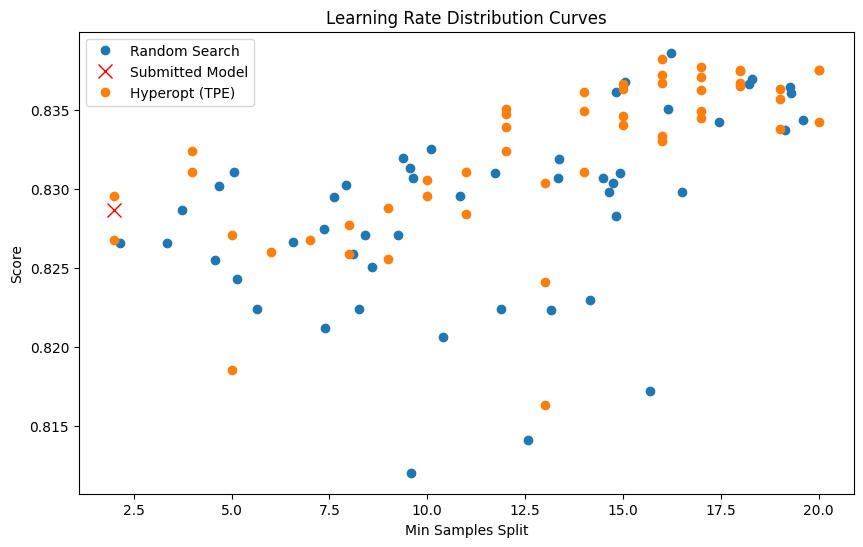

Test ROC AUC: 0.8262626262626263


In [6]:
def main(file_path, target_column):
    # Load and preprocess data
    X_train, X_test, y_train, y_test = load_and_preprocess_data(file_path, target_column)
    
    # Model setup and parameter space
    model = RandomForestClassifier(random_state=42)
    param_space = [(10, 100), (2, 20)]  # Example parameter space
    
    # Random Search
    random_params, random_score, random_learning_rates, random_scores = random_search_optimization(model,X_train, y_train, param_space)

    #submitted model
    submitted_model = RandomForestClassifier(random_state=42, n_estimators=100, min_samples_split=2)
    submitted_score, submitted_min_samples_split = evaluate_submitted_model(submitted_model,X_train, y_train)
    
    # Hyperopt (TPE)
    space = [hp.quniform('n_estimators', 10, 100, 1), hp.quniform('min_samples_split', 2, 20, 1)]
    def objective(params):
        model.set_params(n_estimators=int(params[0]), min_samples_split=int(params[1]))
        score = evaluate_model(model, X_train, y_train)
        return {'loss': -score, 'status': STATUS_OK, 'params': params}
    
    tpe_results, trials, tpe_learning_rates, tpe_scores = tpe_min_custom(objective, space)

    # Results dictionary
    results = {
        'Random Search': {'params': random_params, 'score': random_score, 'learning_rates': random_learning_rates, 'scores': random_scores},
        'Submitted Model': {'min_samples_split': submitted_min_samples_split, 'score': submitted_score},
        'Hyperopt (TPE)': {'params': tpe_results, 'learning_rates': tpe_learning_rates, 'scores': tpe_scores}
    }

    # Visualization
    plot_learning_rate_distribution(results)

    # Final evaluation with the best hyperparameters from TPE
    best_params = tpe_results
    model.set_params(n_estimators=int(best_params['n_estimators']), min_samples_split=int(best_params['min_samples_split']))
    model.fit(X_train, y_train)
    test_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print(f'Test ROC AUC: {test_score}')

# Run the main function
file_path = input("Please enter the path to the data file: ")
target_column = input("Please enter the target column name: ")
main(file_path, target_column)